# Setup

In [ ]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

In [2]:
!pip install vizdoom
!pip install ray 
!pip install ray['rllib']
!pip install Ipython --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 3.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.13-cp37-cp37m-linux_x86_64.whl size=14101153 sha256=1329856396dbbda98b6fb35d9ad709b360277dc1a7704b9d9247b4c2ec3c221e
  Stored in directory: /root/.cache/pip/wheels/ac/37/ae/8e648023f66bb4c473701f94ce126032ff39ad9759ca0645a7
Successfully built vizdoom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 46.5 MB/s 
     |████████████████████████████████| 4.1 MB 26.4 MB/s 
     |████████████████████████████████| 468 kB 56.8 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uni

In [1]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [3]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import shutil
import torch

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create and restore agent from checkpoint


# Initialize Ray

In [5]:

ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")


Shutdown ray


2022-09-24 21:42:29,522	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# Trainer config

In [6]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
#changing this for evaluation time 
config['explore'] = True #for ICM and RE3 might need to be left true to use the exploration module 
config['in_evaluation'] = True


In [7]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass


In [8]:
config["framework"] = "tf"



#https://github.com/ray-project/ray/blob/c9c3f0745a9291a4de0872bdfa69e4ffdfac3657/rllib/utils/exploration/tests/test_random_encoder.py#L35

"""
config["seed"] = 123
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
            "type": "RE3",
            "embeds_dim": 128,
            "beta_schedule": "constant",
            "sub_exploration": {
                "type": "StochasticSampling",
            }
        }
"""

config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     # the dimensionality of the observation embedding vectors in latent space.
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     # Configuration for the encoder network, producing embedding vectors from observations.
     # This can be used to configure fcnet- or conv_net setups to properly process any
     # observation space. By default uses the Policy model configuration.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # Hyperparameter to choose between exploration and exploitation. A higher value of beta adds
     # more importance to the intrinsic reward, as per the following equation
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}

agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-24 21:42:34,130	INFO algorithm.py:1872 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-09-24 21:42:34,132	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-24 21:42:34,139	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.h

(RolloutWorker pid=9605) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=9605) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
(RolloutWorker pid=9605) episode timeout: 1600
(RolloutWorker pid=9605) screen resolution: 320X240
(RolloutWorker pid=9606) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=9606) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
(RolloutWorker pid=9606) episode timeout: 1600
(RolloutWorker pid=9606) screen resolution: 320X240


(RolloutWorker pid=9605) 2022-09-24 21:42:41,589	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=9605) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=9605)   "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
(RolloutWorker pid=9606) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=9606)   "Function `env.seed(seed)` is marked as deprecated and will be removed in 

created agent


In [9]:
# examine the trained policy
#policy = agent.get_policy()
#model = policy.model


#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')
#,
#               config_file="custom\\very_dense_reward.cfg",
#                scenario_file="custom/test/easy_dense_reward_rs.wad") 
#               scenario_file="custom/test/dense_reward_fixed_start.wad") 

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 1600
screen resolution: 320X240


In [20]:
#restore agent from checkpoint 
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward" #_no_tpenalty"
chkpt_dir = 'checkpoint_000100'

chkpt_file = chkpt_root + '/' + chkpt_dir 
print(chkpt_file)


/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000100


In [21]:
agent.restore(chkpt_file)

2022-09-24 21:44:50,044	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000100
2022-09-24 21:44:50,045	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5113.833273887634, '_episodes_total': 2205}


cumulative reward 0.0
total steps: 349
actions: ['forward', 'forward', 'left', 'right', 'right', 'left', 'right', 'right', 'left', 'right', 'left', 'left', 'left', 'forward', 'forward', 'left', 'right', 'left', 'forward', 'left', 'right', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'left', 'right', 'left', 'left', 'left', 'right', 'forward', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'forward', 'left', 'left', 'right', 'right', 'left', 'right', 'right', 'right', 'left', 'right', 'right', 'right', 'right', 'forward', 'right', 'left', 'left', 'left', 'right', 'right', 'forward', 'right', 'left', 'right', 'left', 'left', 'left', 'forward', 'left', 'right', 'forward', 'right', 'right', 'right', 'right', 'left', 'left', 'forward', 'forward', 'left', 'right', 'right', 'forward', 'right', 'left', 'right', 'left', 'forward', 'forw

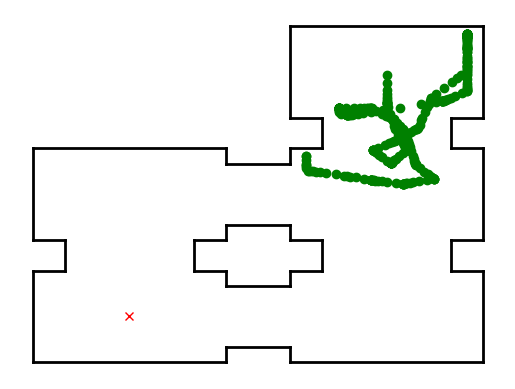

In [24]:
state = env.reset()
sum_reward = 0
n_step = 500#200
path = [] 
actions = [] 
action_string = ['left', 'right', 'forward']

for step in range(n_step):
    action = agent.compute_action(state)
    actions.append(action)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

print(f"actions:", [action_string[x] for x in actions])


import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/no_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, path)

# average reward over all checkpoints 

# Sparse

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)
          
print(chkpt_mean_rewards)


Total number of checkpoints:  26
checkpoint_000001


2022-09-22 15:00:23,947	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000001
2022-09-22 15:00:23,949	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 59.07217836380005, '_episodes_total': 21}


checkpoint_000010


2022-09-22 15:00:35,430	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000010
2022-09-22 15:00:35,432	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 534.9720995426178, '_episodes_total': 238}


checkpoint_000020


2022-09-22 15:00:45,643	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000020
2022-09-22 15:00:45,646	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1061.0097987651825, '_episodes_total': 466}


checkpoint_000030


2022-09-22 15:00:56,650	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000030
2022-09-22 15:00:56,652	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1589.3130543231964, '_episodes_total': 703}


checkpoint_000040


2022-09-22 15:01:05,599	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000040
2022-09-22 15:01:05,603	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2115.9859886169434, '_episodes_total': 931}


checkpoint_000050


2022-09-22 15:01:15,621	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000050
2022-09-22 15:01:15,633	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2639.5114121437073, '_episodes_total': 1167}


checkpoint_000060


2022-09-22 15:01:25,931	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000060
2022-09-22 15:01:25,934	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3162.0341680049896, '_episodes_total': 1407}


checkpoint_000070


2022-09-22 15:01:36,899	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000070
2022-09-22 15:01:36,906	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3688.084823846817, '_episodes_total': 1643}


checkpoint_000080


2022-09-22 15:01:46,300	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000080
2022-09-22 15:01:46,302	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4213.586189031601, '_episodes_total': 1879}


checkpoint_000090


2022-09-22 15:01:56,368	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000090
2022-09-22 15:01:56,370	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4734.723187685013, '_episodes_total': 2121}


checkpoint_000100


2022-09-22 15:02:05,937	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000100
2022-09-22 15:02:05,947	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5258.125777006149, '_episodes_total': 2366}


checkpoint_000110


2022-09-22 15:02:15,572	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000110
2022-09-22 15:02:15,573	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5780.055105924606, '_episodes_total': 2622}


checkpoint_000120


2022-09-22 15:02:25,039	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000120
2022-09-22 15:02:25,041	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6309.644705057144, '_episodes_total': 2868}


checkpoint_000130


2022-09-22 15:02:34,073	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000130
2022-09-22 15:02:34,078	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6846.561623811722, '_episodes_total': 3119}


checkpoint_000140


2022-09-22 15:02:40,987	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000140
2022-09-22 15:02:40,989	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7378.410821437836, '_episodes_total': 3370}


checkpoint_000150


2022-09-22 15:02:48,098	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000150
2022-09-22 15:02:48,105	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7912.999238729477, '_episodes_total': 3643}


checkpoint_000160


2022-09-22 15:02:57,496	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000160
2022-09-22 15:02:57,499	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8451.893983364105, '_episodes_total': 3909}


checkpoint_000170


2022-09-22 15:03:07,787	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000170
2022-09-22 15:03:07,790	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8985.544698238373, '_episodes_total': 4185}


checkpoint_000180


2022-09-22 15:03:18,131	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000180
2022-09-22 15:03:18,134	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9515.946017026901, '_episodes_total': 4461}


checkpoint_000190


2022-09-22 15:03:28,505	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000190
2022-09-22 15:03:28,508	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 10040.189677715302, '_episodes_total': 4749}


checkpoint_000200


2022-09-22 15:03:37,746	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000200
2022-09-22 15:03:37,748	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10563.784615755081, '_episodes_total': 5037}


checkpoint_000220


2022-09-22 15:03:46,582	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000220
2022-09-22 15:03:46,584	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 11638.221982002258, '_episodes_total': 6311}


checkpoint_000240


2022-09-22 15:03:50,272	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000240
2022-09-22 15:03:50,273	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12709.002912521362, '_episodes_total': 8752}


checkpoint_000260


2022-09-22 15:03:54,006	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000260
2022-09-22 15:03:54,009	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 13768.350139856339, '_episodes_total': 11254}


checkpoint_000280


2022-09-22 15:03:59,912	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000280
2022-09-22 15:03:59,914	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 14834.09205031395, '_episodes_total': 13765}
2022-09-22 15:04:01,229	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/sparse/checkpoint_000300
2022-09-22 15:04:01,230	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 15901.771355867386, '_episodes_total': 16278}


checkpoint_000300
[1.0, 1.0, 1.0, 3.5, 2.5, 2.8, 2.9, 2.6, 5.0, 5.1, 2.7, 5.9, 4.5, 8.4, 8.1, 5.3, 5.3, 6.1, 6.2, 8.0, 7.1, 11.1, 11.0, 11.0, 11.0, 11.0]


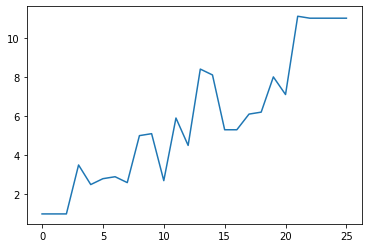

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Dense

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)
          
print(chkpt_mean_rewards)


Total number of checkpoints:  21
checkpoint_000001


2022-09-22 08:32:18,519	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000001
2022-09-22 08:32:18,522	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 64.26672840118408, '_episodes_total': 20}


checkpoint_000010


2022-09-22 08:32:26,769	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000010
2022-09-22 08:32:26,772	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 608.7261974811554, '_episodes_total': 214}


checkpoint_000020


2022-09-22 08:32:34,082	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000020
2022-09-22 08:32:34,083	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1200.950338602066, '_episodes_total': 460}


checkpoint_000030


2022-09-22 08:32:42,051	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000030
2022-09-22 08:32:42,062	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1802.3214251995087, '_episodes_total': 703}


checkpoint_000040


2022-09-22 08:32:49,430	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000040
2022-09-22 08:32:49,431	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2414.5526793003082, '_episodes_total': 961}


checkpoint_000050


2022-09-22 08:32:55,127	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000050
2022-09-22 08:32:55,131	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 3025.5028047561646, '_episodes_total': 1245}


checkpoint_000060


2022-09-22 08:33:02,542	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000060
2022-09-22 08:33:02,548	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3629.8575387001038, '_episodes_total': 1539}


checkpoint_000070


2022-09-22 08:33:08,987	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000070
2022-09-22 08:33:08,991	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4215.710890054703, '_episodes_total': 1821}


checkpoint_000080


2022-09-22 08:33:14,727	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000080
2022-09-22 08:33:14,729	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4786.421822309494, '_episodes_total': 2122}


checkpoint_000090


2022-09-22 08:33:22,478	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000090
2022-09-22 08:33:22,480	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5361.624200582504, '_episodes_total': 2431}
2022-09-22 08:33:28,893	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000100
2022-09-22 08:33:28,896	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5939.429048061371, '_episodes_total': 2753}


checkpoint_000100
checkpoint_000110


2022-09-22 08:33:35,536	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000110
2022-09-22 08:33:35,538	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 6514.538208246231, '_episodes_total': 3076}


checkpoint_000120


2022-09-22 08:33:42,100	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000120
2022-09-22 08:33:42,102	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 7100.463448524475, '_episodes_total': 3400}


checkpoint_000130


2022-09-22 08:33:47,555	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000130
2022-09-22 08:33:47,559	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 7680.730005264282, '_episodes_total': 3720}


checkpoint_000140


2022-09-22 08:33:53,107	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000140
2022-09-22 08:33:53,109	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 8260.58019208908, '_episodes_total': 4077}


checkpoint_000150


2022-09-22 08:33:58,136	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000150
2022-09-22 08:33:58,139	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 8839.500913858414, '_episodes_total': 4445}


checkpoint_000160


2022-09-22 08:34:02,940	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000160
2022-09-22 08:34:02,942	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 9416.570338726044, '_episodes_total': 4826}


checkpoint_000170


2022-09-22 08:34:09,068	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000170
2022-09-22 08:34:09,070	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 9988.922036409378, '_episodes_total': 5178}


checkpoint_000180


2022-09-22 08:34:15,118	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000180
2022-09-22 08:34:15,120	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 10563.575846910477, '_episodes_total': 5536}


checkpoint_000190


2022-09-22 08:34:21,228	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000190
2022-09-22 08:34:21,236	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 11162.11372256279, '_episodes_total': 5904}


checkpoint_000200


2022-09-22 08:34:26,713	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000200
2022-09-22 08:34:26,718	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 11783.072212696075, '_episodes_total': 6243}


[2.0, 5.2, 7.0, 10.0, 12.1, 6.4, 10.3, 11.8, 10.5, 11.6, 11.2, 9.9, 11.3, 11.1, 14.1, 16.4, 14.9, 16.2, 14.3, 9.8, 15.4]


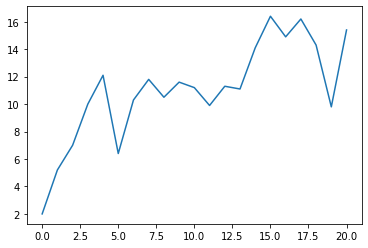

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# easy dense 

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)


          
chkpt_mean_rewards



2022-09-21 23:18:45,929	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000001
2022-09-21 23:18:45,932	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 64.96083569526672, '_episodes_total': 42}


Total number of checkpoints:  11
checkpoint_000001


2022-09-21 23:18:51,833	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000010
2022-09-21 23:18:51,838	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 581.8988029956818, '_episodes_total': 452}


checkpoint_000010


2022-09-21 23:18:55,463	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000020
2022-09-21 23:18:55,467	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1157.5595436096191, '_episodes_total': 913}


checkpoint_000020


2022-09-21 23:18:59,147	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000030
2022-09-21 23:18:59,150	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1730.6989047527313, '_episodes_total': 1394}


checkpoint_000030


2022-09-21 23:19:02,888	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000040
2022-09-21 23:19:02,890	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2313.8183403015137, '_episodes_total': 1859}


checkpoint_000040


2022-09-21 23:19:06,656	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000050
2022-09-21 23:19:06,658	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2887.5175592899323, '_episodes_total': 2327}


checkpoint_000050


2022-09-21 23:19:10,422	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000060
2022-09-21 23:19:10,424	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3463.4613485336304, '_episodes_total': 2814}


checkpoint_000060


2022-09-21 23:19:14,166	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000070
2022-09-21 23:19:14,169	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4040.0543451309204, '_episodes_total': 3322}


checkpoint_000070


2022-09-21 23:19:17,707	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000080
2022-09-21 23:19:17,709	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4613.855907201767, '_episodes_total': 3843}


checkpoint_000080


2022-09-21 23:19:21,344	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000090
2022-09-21 23:19:21,347	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5186.688502073288, '_episodes_total': 4327}


checkpoint_000090


2022-09-21 23:19:24,988	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000100
2022-09-21 23:19:24,993	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5763.028538942337, '_episodes_total': 4847}


checkpoint_000100


[0.0, 0.0, 0.0, 0.2, 0.1, 0.0, 1.0, 2.5, 2.0, 1.9, 2.0]

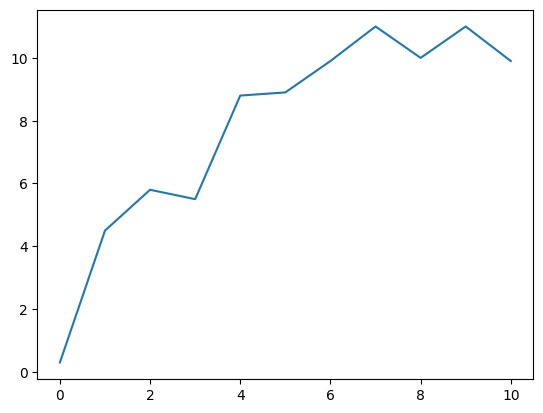

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

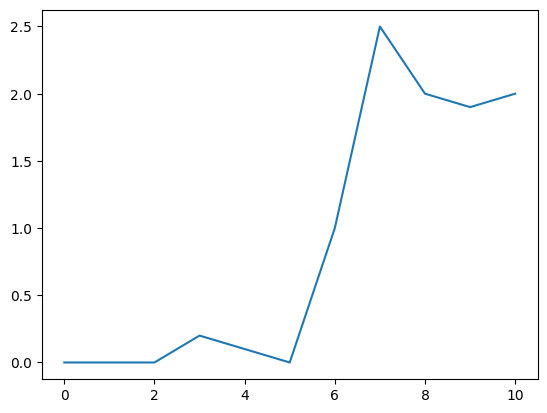

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()